In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch # for CIFAR
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import PIL
from PIL import Image
np.random.seed(1)

### Getting the IITH Image and CIFAR
---
The IITH image is preprocesssed and cropped using `PIL`, We use torchvision to get the CIFAR dataset.
> All the functions have been written to accept images of the shape (H, W, C).

Since the input batch will have images of shape C, H, W we need to use the `permute` function to permute the axes.

RGB
('R', 'G', 'B')
(820, 869)


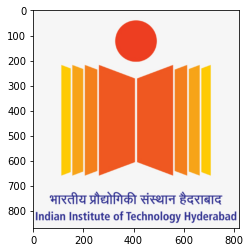

In [38]:
# import the IITH Image from the directory
img = Image.open('IITH.png')
print(img.mode)
print(img.getbands())
img = img.convert('RGB')
plt.imshow(img)
print(img.size)


(820, 869)
('R', 'G', 'B')
(820, 820, 3)


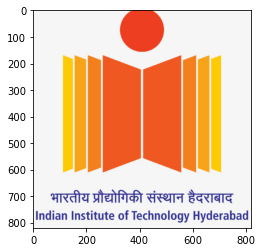

In [39]:
print(img.size)
img = img.crop((0, 49, 820, 869))
arr = np.array(img)
print(img.getbands())
print(arr.shape)
iith = arr
plt.imshow(iith)
# normalize iith
iith = iith/255

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./Datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)
iterator = iter(testloader)
images, labels = next(iterator)

Files already downloaded and verified


In [41]:
print(images.shape)
image = images[0].permute(1,2,0)

torch.Size([10000, 3, 32, 32])


#### Generating a batch of images using all the labels
---

Here we generate a batch of images of 3 images from each of the 100 classes that are present in CIFAR

In [42]:
batch = []
for label in range(10):
    pos = np.where(labels == label)
    top_3 = pos[0][:3]
    print(top_3)
    image_set = [images[i] for i in top_3]
    image_set = [image.permute(1,2,0) for image in image_set]
    batch += image_set

[ 3 10 21]
[ 6  9 37]
[25 35 65]
[ 0  8 46]
[22 26 32]
[12 16 24]
[4 5 7]
[13 17 20]
[ 1  2 15]
[11 14 23]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


Text(0.5, 1.0, 'Normalized CIFAR image')

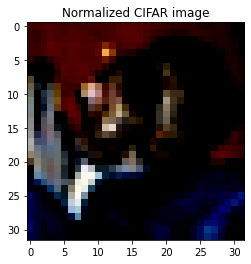

In [43]:
print(len(batch))
plt.imshow(image)
plt.title('Normalized CIFAR image')

##### Activation Functions
---
The following activation functions use broadcasting to perform the operation on the entire image or vector

In [44]:
def tanh(input_vector):
    return np.tanh(input_vector)

In [45]:
def RELU(x):
    return np.maximum(0,x)

In [46]:
def sigmoid(input_space): # should work for both sheets and vectors
    return np.exp(-np.logaddexp(0., -input_space)) #### Numerically stable version of the sigmoid function

#### Softmax Layer
---

The implementation removes the maximum value from both the numerator and denominator exponentials to avoid overflow.
THe value will not change, clearly

In [47]:
def softmax(x):
    x = x - np.max(x, axis = 0, keepdims=True) # for numerical stability of the softmax function
    return np.exp(x)/np.sum(np.exp(x), axis = 0)

### Convolution

---

There are three functions, the activation function can be passed as an argument
1. `convolve` This function just convolves a 2d sheet with a 2d filter
2. `convolve_image` This function convolves a 3d image with a 3d filter ( through all channels )
3. `conv2d` This is a `layer function`  that convolves an input volume with the number of required output filters using the first 2 functions. The filters are randomly initialized. 

In [48]:
def convolve(sheet, kernel, stride = 1, padding = 2, activation = sigmoid):
    kernel_size = kernel.shape[0]
    output_image = np.zeros((int((sheet.shape[0] - kernel_size + 2*padding)/stride) + 1, int((sheet.shape[1] - kernel_size + 2*padding)/stride) + 1))
    sheet = np.pad(sheet, padding, 'constant')
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            output_image[i, j] = np.sum(sheet[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size] * kernel)
            # print(output_image[i, j])
    return (output_image)

In [49]:
kernel = np.ones((3, 3))
op = convolve(np.ones((5, 5)), kernel, stride = 2, padding = 0)
print(np.ones((5, 5)))
print(kernel)
print(op.shape)
print(op)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
(2, 2)
[[9. 9.]
 [9. 9.]]


In [50]:
def convolve_image(image, kernel, stride, padding, activation = sigmoid):
    channels = image.shape[2]
    if(kernel.shape[2] != channels):
        print("Error: Kernel and Image not conformable")
        return
    else:
        output_size = int((image.shape[0] - kernel.shape[0] + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        channel_sum = np.zeros_like(output_image)
        for i in range(channels):
            channel_sum += convolve(image[:, :, i], kernel[:, :, i], stride, padding, activation)
        output_image = channel_sum
        return activation(output_image)

In [51]:
kernel = np.random.randn(3, 3, 3)
sigma_grindset = convolve_image(iith, kernel, 1, 0)
op2 = convolve_image(iith, kernel, 1, 0, activation = RELU)
op3 = convolve_image(iith, kernel, 1, 0, activation = tanh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


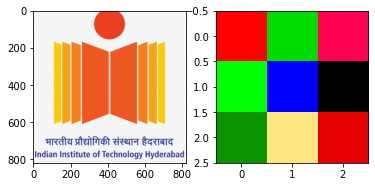

In [52]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(iith)
ax[1].imshow(kernel)

Text(0.5, 1.0, 'Tanh')

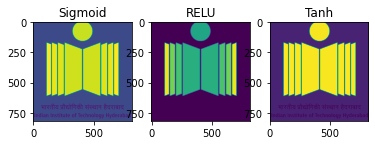

In [53]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(sigma_grindset)
ax[0].set_title('Sigmoid')
ax[1].imshow(op2)
ax[1].set_title('RELU')
ax[2].imshow(op3)
ax[2].set_title('Tanh')

In [54]:
def conv2d(input_volume, out_channels, kernel_size, stride = 1, padding = 0, activation = sigmoid):
    in_shape= input_volume.shape[0]
    in_channels = input_volume.shape[2]
    kernels = np.random.randn(out_channels, kernel_size, kernel_size, in_channels)
    output_size = int((in_shape - kernel_size + 2*padding)/stride) + 1
    output_volume = np.zeros((output_size, output_size, out_channels))
    # print(output_volume.shape)
    for i in range(out_channels):
        output_volume[:,:,i] = convolve_image(input_volume, kernels[i], stride, padding, activation)
    return (output_volume)

In [55]:
op = conv2d(np.ones((5, 5, 3)), 7, 3, 1, 0)
print(op.shape)

(3, 3, 7)


#### Pooling
---
There are two functions

1. `pool_image` This function just pools a 2d image with a 2d filter
2. `pool2d` This is a `layer function`  that pools an input volume with the number of required output filters using the first 2 functions. The filters are randomly initialized.
3. `GAP` is a separate function that performs Global Average Pooling on the input volume

In [56]:
def pool_image(image, kernel_size, stride=1, padding=0, option = "max"):
    if(option == "max"):
        output_size = int((image.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        for i in range(output_image.shape[0]):
            for j in range(output_image.shape[1]):
                output_image[i, j] = np.max(image[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size])
        return output_image
    elif(option == "avg"):
        output_size = int((image.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        for i in range(output_image.shape[0]):
            for j in range(output_image.shape[1]):
                output_image[i, j] = np.mean(image[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size])
        return output_image
        
    

In [57]:
def GAP(input_volume, padding = 0):
    output_volume = np.zeros((1, 1, input_volume.shape[2]))
    for i in range(input_volume.shape[2]):
        output_volume[0, 0, i] = np.mean(input_volume[:, :, i])
    return output_volume

In [58]:
def pool2d(input_volume, kernel_size, stride, padding, mode = "avg"):
    input_channels = input_volume.shape[2]
    if(mode == "avg"):
        output_size = int((input_volume.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_volume = np.zeros((output_size, output_size, input_channels))
        for i in range(input_channels):
            output_volume[:, :, i] = pool_image(input_volume[:, :, i], kernel_size, stride, padding, "avg")
    elif(mode == "max"):
        output_size = int((input_volume.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_volume = np.zeros((output_size, output_size, input_channels))
        for i in range(input_channels):
            output_volume[:, :, i] = pool_image(input_volume[:, :, i], kernel_size, stride, padding, "max")
    else:
        output_volume = GAP(input_volume, padding) 
    return output_volume

In [59]:
x = np.random.randn(5, 5, 3)
pool2d(x, 3, 1, 0, "GAP")

array([[[-0.11094092,  0.16504312,  0.15630786]]])

In [69]:
op4 = pool_image(iith[:, :, 0], 3, 1, 0, "max")
print(op4.shape)

(818, 818)


### Flattening and MLP
---

The `flatten` function flattens the input volume into a vector. The `MLP` function is a `layer function` that performs a linear transformations followed by a fixed activation function. The weights are randomly initialized.

In [61]:
def flatten(input_volume, output_size=None):
    if(output_size is None):
        output_size = input_volume.shape[0]*input_volume.shape[1]*input_volume.shape[2]
    x_flat = input_volume.reshape((input_volume.shape[0]*input_volume.shape[1]*input_volume.shape[2], 1))
    weights = np.random.randn(output_size, input_volume.shape[0]*input_volume.shape[1]*input_volume.shape[2])
    return np.dot(weights, x_flat)

In [62]:
def MLP(input_vector, sizes, activation=sigmoid):
    sizes = [input_vector.shape[0]] + sizes
    output = input_vector
    # print(len(sizes))
    weights = [np.random.randn(sizes[i+1], sizes[i]) for i in range(len(sizes) - 1)]
    biases = [np.random.randn(sizes[i+1], 1) for i in range(len(sizes) - 1)]
    for i in range(len(sizes) - 1):
        output = activation(np.dot(weights[i],output) + biases[i])
    return output

In [63]:
input_vector = np.random.randn(5, 1)
sizes = [5, 6, 7, 2]
MLP(input_vector, sizes)

array([[0.80433788],
       [0.09688759]])

#### CNN
---

The layers are defined within according to the question and then the forward pass is tested on top of the CIFAR image

In [64]:
class ConvolutionalNet:
    def __init__(self):
        self.input = None
        self.output = None
        self.bottle_neck = None
    def forward(self, x_in):
        self.input = x_in
        x = x_in
        x = conv2d(x, 16, 3, 1, 0, sigmoid)
        x = pool2d(x, 2, 2, 0, "max")
        x = conv2d(x, 8, 3, 1, 0, sigmoid)
        x = pool2d(x, 2, 2, 0, "max")
        x = GAP(x, 0)
        x = flatten(x)
        self.bottle_neck = x
        x = MLP(x, [x.shape[0], 10], sigmoid)
        x = softmax(x)
        self.output = x
        return x
    def get_bottle_neck(self):
        return self.bottle_neck

In [65]:
net = ConvolutionalNet()
x = net.forward(image)
print(x.shape)

(10, 1)


#### Bootlenecks and PCA, analysing Discriminability
---

The bottlenecks are obtained after extracting the vectors from the layer just before the classifier MLP and the softmax.
This shows us the ability of the CNN and the pooling layers to extract features from the images.
When we use the PCA to analyze it for randomly initialized weights, we see that the features learnt are not discriminative in any way ( they should not be since the distribution is perfectly random ), and our architecture does not create a bias between any of the classes at all.

In [66]:
bottlenecks = np.zeros((len(batch), net.get_bottle_neck().shape[0]))
outputs =  []
pred_labels = []
i = 0
for image in batch:
    op = net.forward(image)
    bn = net.get_bottle_neck()
    pred_label = np.argmax(op, axis = 0)
    pred_labels.append(pred_label)
    bottlenecks[i, :] = bn.reshape((bn.shape[0],))
    outputs.append(op)
    i = i + 1

In [67]:
print(bottlenecks.shape)
pca = PCA(n_components=2)
Embeddings = pca.fit_transform(bottlenecks)
print(Embeddings.shape)

(30, 8)
(30, 2)


Text(0.5, 1.0, 'PCA Embeddings of each class')

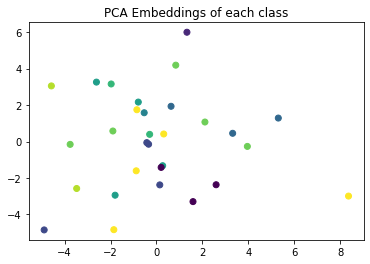

In [68]:
plt.scatter(Embeddings[:, 0], Embeddings[:, 1], c = pred_labels)
plt.title("PCA Embeddings of each class")